In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
#  import matplotlib.pyplot as plt
import pylab
import os
import pydicom
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from skimage import measure
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input,\
UpSampling2D, LeakyReLU, Conv2D, MaxPool2D
# , AvgPool2D, Lambda, LocallyConnected2D, Conv2D, multiply, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\
    # , LearningRateScheduler
from keras.losses import binary_crossentropy
from keras.utils import Sequence
from keras import layers
import keras_preprocessing.image as KPImage

BASE_MODEL = 'DenseNet121' # ['InceptionV3', 'Xception', 'DenseNet169', 'VGG16']
IMG_SIZE =  (224, 224)
BATCH_SIZE = 64
DENSE_COUNT = 128
DROPOUT = 0.25
LEARN_RATE = 1e-4
TRAIN_SAMPLES = 8000
TEST_SAMPLES = 800
USE_ATTN = False

Using TensorFlow backend.


In [5]:
# Initialize paths to image directories
det_class_path = '../input/stage_1_detailed_class_info.csv'
bbox_path = '../input/stage_1_train_labels.csv'
dicom_dir = '../input/stage_1_train_images/'

# Labels contains the target (1=pneumonia, 0=healthy) and bounding boxes
# if that patient has pneumonia
bbox_df = pd.read_csv(bbox_path)

# Create new column grouping together bounding box parameters into list
bbox_df[['x', 'y', 'width', 'height']] = \
    bbox_df[['x', 'y', 'width', 'height']].fillna(0.0).astype('int')

# Create new dataframe with a column bbox which contains the info about 
# the bounding box
comb_bbox_df = bbox_df
comb_bbox_df['bbox'] = bbox_df[['x', 'y', 'width', 'height']].values.tolist()

# Now group together multiple bounding boxes for each patient into another list
# If the patient is healthy then this list will contain [0,0,0,0] indicating no bboxs
grouped_bbox_df = comb_bbox_df.groupby('patientId')['bbox'].apply(list)
grouped_bbox_df.head(10)

patientId
0004cfab-14fd-4e49-80ba-63a80b6bddd6                                  [[0, 0, 0, 0]]
00313ee0-9eaa-42f4-b0ab-c148ed3241cd                                  [[0, 0, 0, 0]]
00322d4d-1c29-4943-afc9-b6754be640eb                                  [[0, 0, 0, 0]]
003d8fa0-6bf1-40ed-b54c-ac657f8495c5                                  [[0, 0, 0, 0]]
00436515-870c-4b36-a041-de91049b9ab4    [[264, 152, 213, 379], [562, 152, 256, 453]]
00569f44-917d-4c86-a842-81832af98c30                                  [[0, 0, 0, 0]]
006cec2e-6ce2-4549-bffa-eadfcd1e9970                                  [[0, 0, 0, 0]]
00704310-78a8-4b38-8475-49f4573b2dbb    [[323, 577, 160, 104], [695, 575, 162, 137]]
008c19e8-a820-403a-930a-bc74a4053664                                  [[0, 0, 0, 0]]
009482dc-3db5-48d4-8580-5c89c4f01334                                  [[0, 0, 0, 0]]
Name: bbox, dtype: object

In [128]:
# we create two instances with the same arguments and a 10% validation split
data_gen_args = {'validation_split': 0.1}
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 2018

image_dir = dicom_dir + 'sources'
target_dir = dicom_dir + 'masks'

train_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
train_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training')
valid_image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')
valid_mask_generator = mask_datagen.flow_from_directory(
    target_dir,
    class_mode=None,
    seed=seed,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation')

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)
valid_generator = zip(valid_image_generator, valid_mask_generator)

Found 23116 images belonging to 1 classes.
Found 23116 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.
Found 2568 images belonging to 1 classes.


In [7]:
# This takes a while and only needs to be ran once to generate all the necessary images

#for pid, boxes in grouped_bbox_df.items():
    #if os.path.isfile(os.path.join(dicom_dir, "src/" + str(pid) + ".png")):
    #    continue
    #if os.path.isfile(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png")):
    #    continue
    # load dicom file as numpy array

#    img = pydicom.dcmread(os.path.join(dicom_dir, str(pid) + ".dcm")).pixel_array
    # create empty mask
#    msk = np.zeros(img.shape, dtype=np.uint8)
    
#    if boxes[0] != [0,0,0,0]:
        # loop through bounding boxes
#        for box in boxes:
            # add 1's at the locations indicating pneumonia
#            x, y, w, h = box
#            msk[y:y + h, x:x + w] = 255
            
    
#    msk2 = np.repeat(msk[:,:,np.newaxis], 3, axis=2)
    #msk2 = resize(msk2, (IMG_SIZE[0], IMG_SIZE[1], 3), mode='reflect')
    
#    msk3 = Image.fromarray(msk2, 'RGB')
#    msk3.thumbnail(IMG_SIZE)
    #if boxes[0] != [0,0,0,0]:
        # msk3.show()
#    msk3.save(os.path.join(dicom_dir, "masks/msk/" + str(pid) + "-mask.png"))
    
    # resize image and scale up to 8bit colorspace, dont need to multiply by 255
#    img2 = np.repeat(img[:,:,np.newaxis], 3, axis=2)
#    img3 = Image.fromarray(img2, 'RGB')
#    img3.thumbnail(IMG_SIZE)
#    img3.save(os.path.join(dicom_dir, "sources/src/" + str(pid) + ".png"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3) (64, 224, 224, 3)


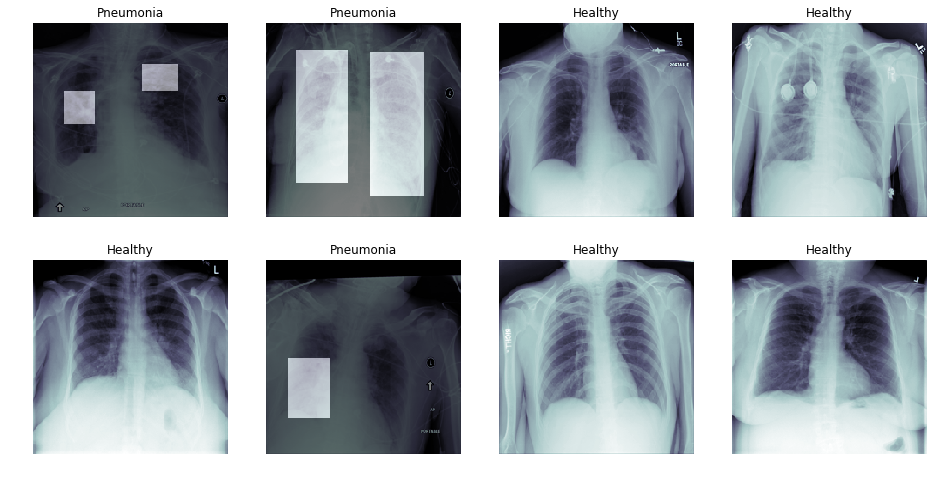

In [8]:
train_src, train_tar = next(train_generator)
valid_src, valid_tar = next(valid_generator)

print(train_src.shape, train_tar.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (t_src, t_tar, ax) in zip(train_src, train_tar, m_axs.flatten()):
    ax.imshow(t_src[:,:,0], cmap = 'bone')
    if np.all(t_tar<1):
        # If the mask is all 0 then there's no pneumonia
        title = 'Healthy'
    else:
        title = 'Pneumonia'
        ax.imshow(t_tar[:,:,:], alpha=0.5)
    ax.set_title('%s' % title)
    ax.axis('off')

In [9]:
base_pretrained_model = PTModel(input_shape = train_src.shape[1:], 
                                include_top = False)
base_pretrained_model.trainable = False
base_pretrained_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [10]:
# This is the percentage overlap between predicted box and actual
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    split0, split1, split2 = tf.split(y_true, num_or_size_splits=3, axis=3)
    split0 = tf.round(tf.divide(split0, 255))
    return iou_loss(split0, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    split0, split1, split2 = tf.split(y_true, num_or_size_splits=3, axis=3)
    split0 = tf.round(tf.divide(split0, 255))
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(split0 * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(split0, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [205]:
def gen_data(gen, model, return_images=False, exclude_neg=True):
    X = []
    y = []
    src_out = []
    tar_out = []
    src, tar = next(gen)
    preds = model.predict(src, batch_size = BATCH_SIZE)
    feat_width, feat_height, depth = preds[0].shape

    for src_img, tar_msk, pred in zip(src, tar, preds):
        if not tar_msk.any() and exclude_neg:
            # This will get only cases with boxes to provide more positive cases
            continue
        if return_images:
            src_out.append(src_img)
            tar_out.append(tar_msk)
        
        msk_7x7 = resize(tar_msk, (7, 7, 1), mode='reflect', anti_aliasing=False)
        msk_7x7[msk_7x7 > 0] = 1
        [y.append(val) for val in msk_7x7.flatten()]
        for i in range(feat_width):
            for j in range(feat_height):
                X.append(pred[i][j])
    if return_images:
        return (X, y, src_out, tar_out)
    else:
        return (X, y)

In [167]:
from sklearn import svm

clf = svm.SVC(C=100, gamma='scale')
X_train = []
y_train = []

for _ in range(40):  # range(len(grouped_bbox_df)/BATCH_SIZE):
    X, y = gen_data(train_generator, base_pretrained_model)
    [X_train.append(val) for val in X]
    [y_train.append(val) for val in y]
                
#print("Starting Training")
clf.fit(X_train, y_train)

64/64 [==============================] - 0s 5ms/step


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [206]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 3, 5, 8, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)

X_train = []
y_train = []

for _ in range(40):  # range(len(grouped_bbox_df)/BATCH_SIZE):
    X, y = gen_data(train_generator, base_pretrained_model)
    [X_train.append(val) for val in X]
    [y_train.append(val) for val in y]
                
#print("Starting Training")
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 3, 5, 8, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [204]:
print(clf.cv_results_["split0_train_score"])
print(clf.cv_results_["split0_test_score"])

[0.98584244 1.         1.        ]
[0.89275037 0.88602392 0.88602392]


In [170]:
from sklearn.externals import joblib
# joblib.dump(clf, 'densenet_svm.joblib') 

# clf = joblib.load('densenet_svm.joblib')
print([True for val in y_train if val != 0 if val != 1]) # Confirm only 2 classes
print(len(X_train))
clf.n_support_

[]
26019


array([6236, 2675], dtype=int32)

In [171]:
X_valid = []
y_valid = []

all_p = []
output = []
tp = []
all_y = []
for _ in range(10):
    X_valid, y_valid = gen_data(valid_generator, base_pretrained_model)
    [all_y.append(val) for val in y_valid]
    for i in range(len(X_valid)):
        prediction = clf.predict([X_valid[i]])[0]
        all_p.append(prediction)  # All true values
        output.append(prediction == y_valid[i])  # All correct, pos and neg
        tp.append(prediction * y_valid[i])  # True positive, where it says 1 and it is

print(len(output))
print(sum(output)/len(output))  # Precision
print((sum(all_p), sum(all_y)))
print(sum(tp)/sum(all_y))  # Recall more important because most vectors will be 0
# C = 100000: 0.379281537176274 / 20 train batch: 0.4097771387491014
# C = 10000 : 0.37610264635124296
# C = 1000  : 0.350354609929078
# C = 100   : 0.38436692506459946
# C = 10    : 0.32

64/64 [==============================] - 0s 4ms/step
10045
0.8792434046789448
(936.0, 1335.0)
0.3962546816479401


64/64 [==============================] - 0s 5ms/step
3136


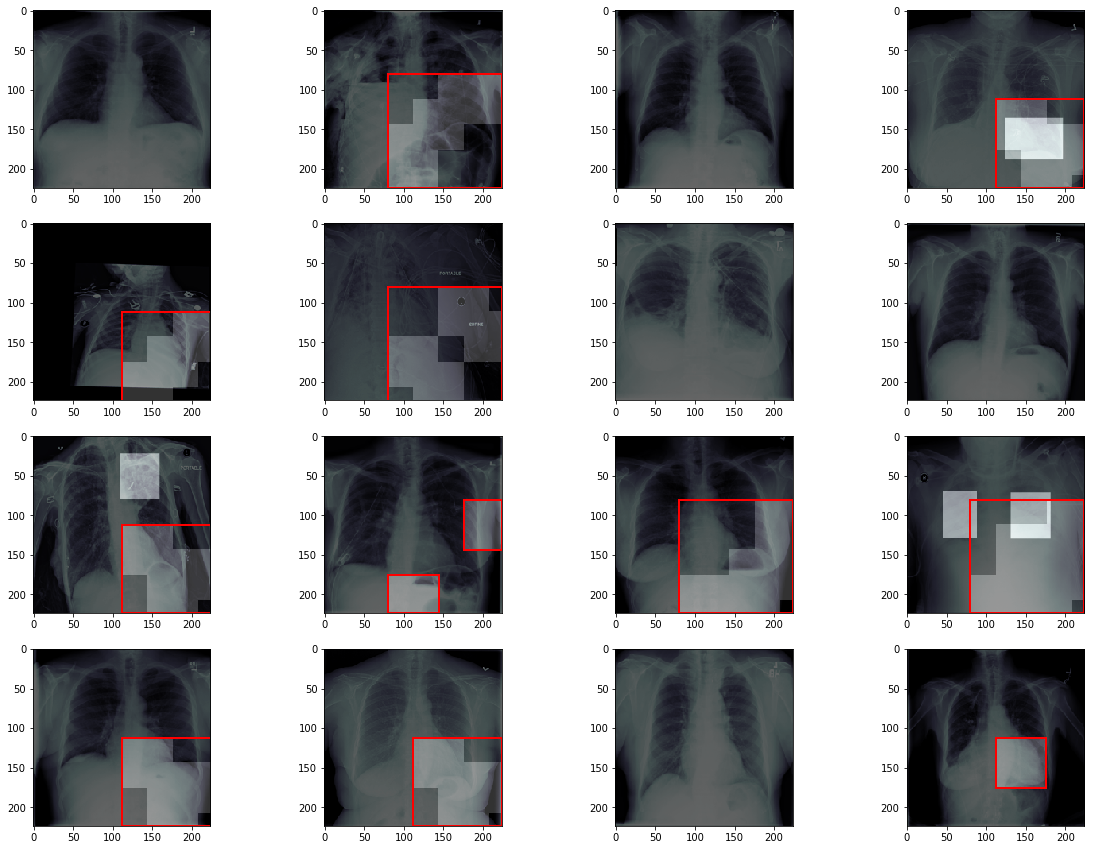

In [191]:
images_wide = 4
images_high = 4
total_images = images_wide * images_high

f, axarr = plt.subplots(images_wide, images_high, figsize=(20,15))
axarr = axarr.ravel()
axidx = 0
    
while(axidx < total_images):
    """
    msk_7x7 = resize(tar_msk,
                     (7, 7, 3),
                     mode='constant',
                     anti_aliasing=False)
    msk_7x7 = resize(msk_7x7,
                     (224, 224, 3),
                     mode='constant',
                     anti_aliasing=False) """
   
    # msk_7x7[msk_7x7 > 0] = 1
    # pred_ax.imshow(msk_7x7[:,:,:], alpha=0.5)
    
    X_test, y_test, test_img, test_msk = gen_data(valid_generator,
                                                  base_pretrained_model,
                                                  return_images=True,
                                                  exclude_neg=False)
    print(len(X_test))
    for img_no in range(BATCH_SIZE):
        if axidx >= total_images:
            break
        # Add the scan image and true mask to the image
        axarr[axidx].imshow(test_img[img_no][:,:,0], cmap = 'bone')
        axarr[axidx].imshow(test_msk[img_no][:,:,:]/255, alpha=0.5, cmap = 'bone')
        
        comp = np.empty([feat_width, feat_height])
        for i in range(feat_width):
            for j in range(feat_height):
                # Height and width offset by image number
                current_pixel = i*j+(img_no*feat_width*feat_height)
                comp[i][j] = clf.predict([X_test[current_pixel]])[0]
        
        comp = resize(comp,
                      (224, 224, 1),
                      mode='constant',
                      anti_aliasing=False)
        comp[comp>0] = 1
        axarr[axidx].imshow(comp[:,:,0], alpha=0.2, cmap = 'bone')
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),
                                                     width,
                                                     height,
                                                     linewidth=2,
                                                     edgecolor='r',
                                                     facecolor='none'))
        axidx += 1
    plt.show()
    break
    # only plot one batch

NameError: name 'history' is not defined

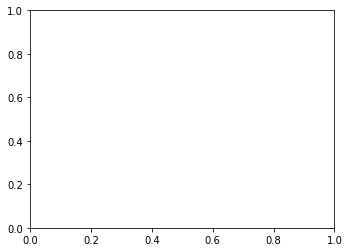

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.title("IOU Loss")
#plt.subplot(132)
#plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
#plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
#plt.legend()
plt.subplot(122)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.title("Mean IOU")
plt.show()